# Initialization

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy.stats import pearsonr

## read and prepare data

In [37]:
df = pd.read_excel(r'sc2 unit stats.xlsx')


In [38]:
df = df.replace('-', 0)

In [39]:
df.rename(columns=lambda x: x.replace(' ','_'), inplace=True)

In [40]:
# df.info()

In [41]:
for column in ['HP', 'Armor', 'Ground_DPS', 'Air_DPS', 'Speed']:
    # print(column)
    for i in df[column].index:
        value = df[column][i]
        # catch values str like '45 (+10)', but not int 45
        if type(value) is str:
            base = float(value.split('(')[0])
            bonus = float(value[value.find('(')+1 : value.find(')')])
            # print(f'{value} -> {base}, {bonus}')
            df.at[i, column] = base
            df.at[i, column+'_bonus'] = bonus
    # print(df[column].unique())
    # print(df[column+'_bonus'].unique())

In [42]:
df.fillna(0, inplace=True)

df.drop(df.index[df.Tier == 0], inplace=True)

df = df.convert_dtypes()

df.Race = df.Race.astype('category')

In [43]:
%%time
df['Psionic'] = df.Attribut.str.contains('P')
# TODO make exception for Archon - he's psionic, but not caster
# df.loc['Psionic'df.Unit == 'Archon'] = False

Wall time: 1 ms


In [44]:
# tier_values = {'0':0, 'D':1, 'C':2, 'B':4, 'A':8, 'S':16}
tier_values = {0:0, 'D':1, 'C':2, 'B':3, 'A':4, 'S':5}
df['Tier_value'] = df.Tier.apply(lambda x: tier_values[x])

In [45]:
df.Creep_bonus = df.Creep_bonus.apply(lambda v: float(str(v).replace('x', '')) )
df.Creep_bonus.replace(0, 1, inplace=True)
df['Max_speed'] = (df.Speed + df.Speed_bonus) * df.Creep_bonus

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 69
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Unit              61 non-null     string  
 1   Tier              61 non-null     string  
 2   Race              61 non-null     category
 3   Supply            61 non-null     Float64 
 4   Minerals          61 non-null     Int64   
 5   Gas               61 non-null     Int64   
 6   Building_time     61 non-null     object  
 7   Size              61 non-null     Float64 
 8   Cargo             61 non-null     Int64   
 9   Armor             61 non-null     Int64   
 10  HP                61 non-null     Int64   
 11  Shields           61 non-null     Int64   
 12  Attribut          61 non-null     string  
 13  Ground_attack     61 non-null     object  
 14  Air_attack        61 non-null     object  
 15  Bonus             61 non-null     object  
 16  Ground_DPS        61 non-nul

## seaborn setup

In [47]:
sns.set(rc={'figure.figsize':(10,6)}, font_scale=1.1)
sns.set_style('whitegrid')
title_font_size = 20


In [48]:
sc_race_colors = {
    'Protoss':'#edc124',
    'Terran':'#386ca8',
    'Zerg':'#953e9e'
}

tiers_order = ['S','A','B','C','D']

sc_psionic_colors = {True:'#b853c9', False:'#8c8c8c'}

tiers_colors = {
    'S':'#ff8300',  # GML
    'A':'#0298f2',  # ML
    'B':'#e6a90e',  # Gold
    'C':'#7d7d82',  # Silver
    'D':'#915937'   # Bronze
}

cmap_gold_gray = mpl.colors.LinearSegmentedColormap.from_list('gold_gray', ['gold','darkgray', 'dimgray'])

# Visualization
## Compare races

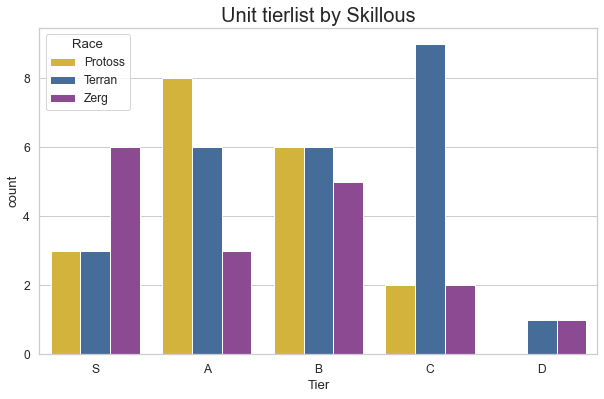

In [49]:
g = sns.countplot(x='Tier', hue='Race', data=df,
              order=tiers_order,
              palette=sc_race_colors)
g.set_title('Unit tierlist by Skillous', fontsize=title_font_size);

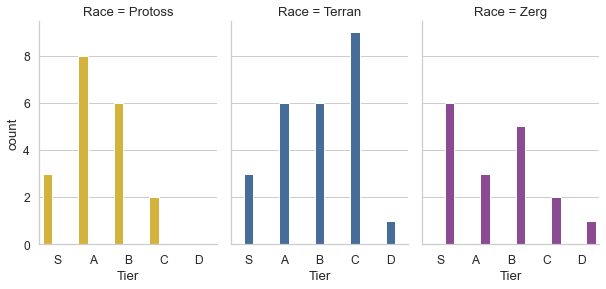

In [50]:
g = sns.catplot(x="Tier", hue="Race", col="Race",
            data=df, kind="count",
            order=tiers_order, palette=sc_race_colors,
            height=4, aspect=.7);

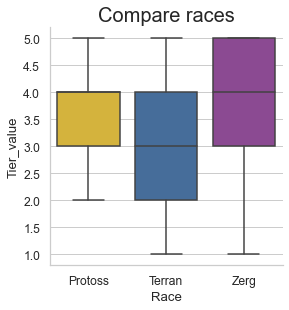

In [51]:
g = sns.catplot(x="Race", y='Tier_value',
            data=df,
            kind='box',
            palette=sc_race_colors,
            height=4)
g.ax.set_title('Compare races', fontsize=title_font_size);

## Casters vs other units

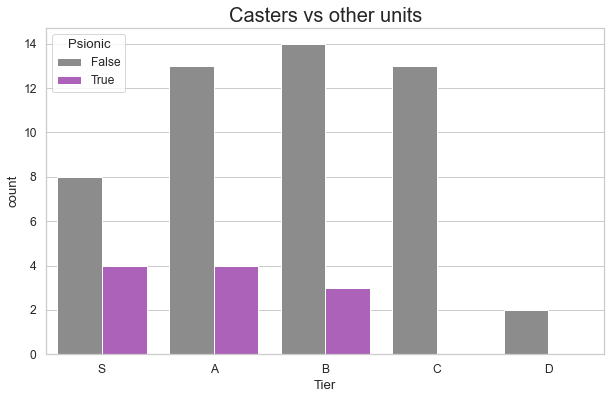

In [52]:
g = sns.countplot(x='Tier', hue='Psionic', data=df,
              order=tiers_order,
              palette=sc_psionic_colors)
g.set_title('Casters vs other units', fontsize=title_font_size);

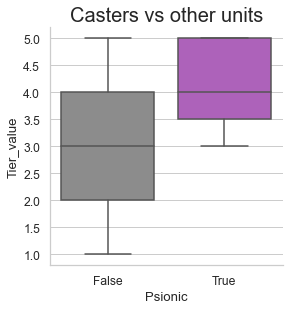

In [53]:
g = sns.catplot(x="Psionic", y='Tier_value',
            data=df,
            kind='box',
            palette=sc_psionic_colors,
            height=4)
g.ax.set_title('Casters vs other units', fontsize=title_font_size);

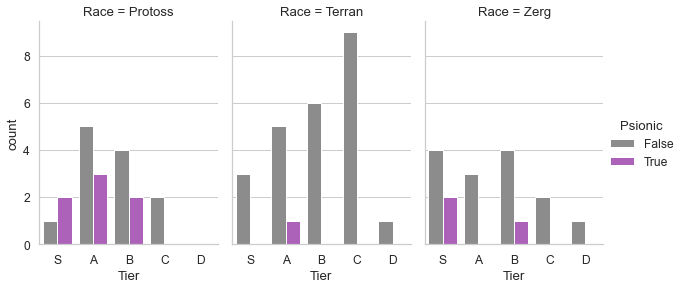

In [54]:
g = sns.catplot(x="Tier", hue="Psionic", col="Race",
            data=df, kind="count",
            order=tiers_order, palette=sc_psionic_colors,
            height=4, aspect=.7);

## Checking dependence of the rating on other parameters

### DPS

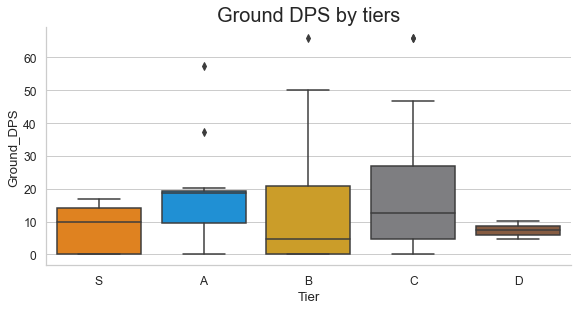

In [77]:
g = sns.catplot(x='Tier', y='Ground_DPS', order=tiers_order,
                data=df[df.Psionic == False],
                palette = tiers_colors,
                kind='box',
                height=4, aspect=2)
g.ax.set_title('Ground DPS by tiers', fontsize=title_font_size);

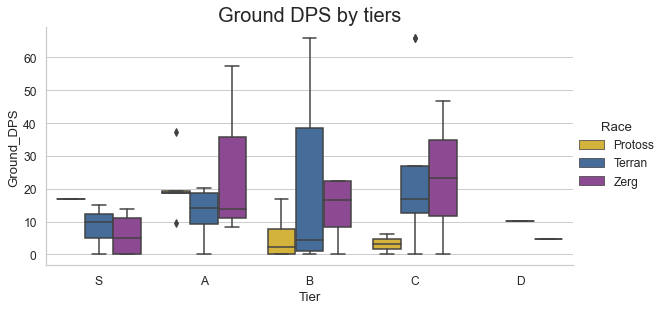

In [56]:
g = sns.catplot(x='Tier', y='Ground_DPS', order=tiers_order,
            data=df[df.Psionic == False],
            kind='box',
            hue='Race', palette=sc_race_colors,
            height=4, aspect=2)
g.ax.set_title('Ground DPS by tiers', fontsize=title_font_size);

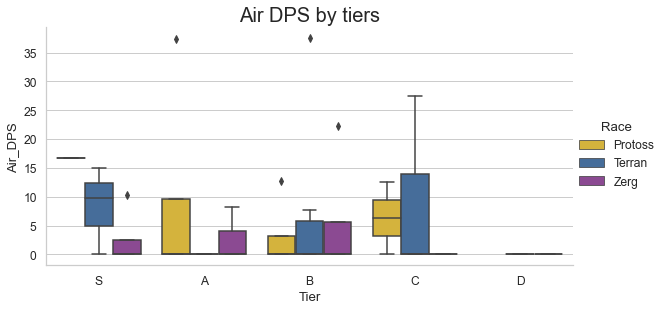

In [57]:
g = sns.catplot(x='Tier', y='Air_DPS', order=tiers_order,
            data=df[df.Psionic == False],
            kind='box',
            hue='Race', palette=sc_race_colors,
            height=4, aspect=2)
g.ax.set_title('Air DPS by tiers', fontsize=title_font_size);

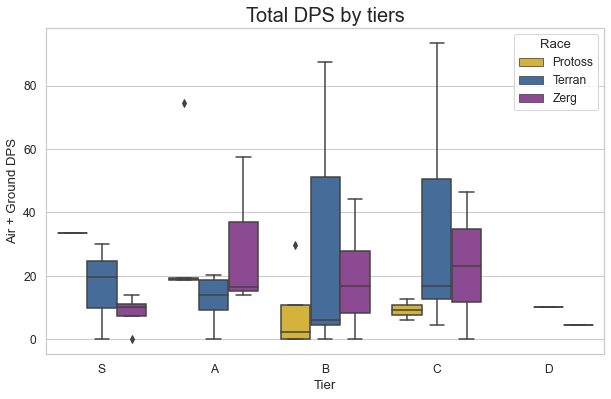

In [58]:
g = sns.boxplot(x=df[df.Psionic == False].Tier, order=tiers_order,
            y=df[df.Psionic == False].Air_DPS + df[df.Psionic == False].Ground_DPS,
            hue=df.Race, palette=sc_race_colors
            )
g.set_ylabel('Air + Ground DPS')
g.set_title('Total DPS by tiers', fontsize=title_font_size);

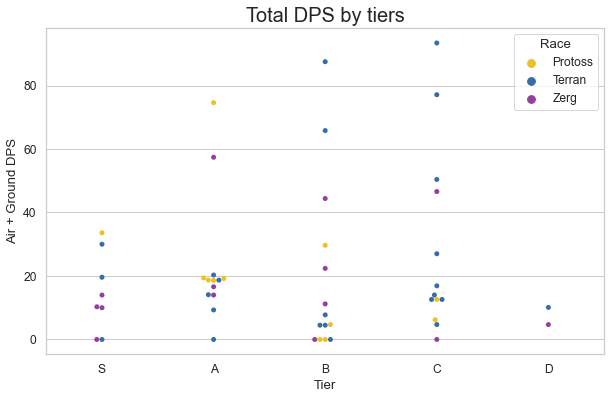

In [59]:
g = sns.swarmplot(x=df[df.Psionic == False].Tier, order=tiers_order,
            y=df.Air_DPS + df.Ground_DPS,
            hue=df.Race, palette=sc_race_colors
            )
g.set_ylabel('Air + Ground DPS')
g.set_title('Total DPS by tiers', fontsize=title_font_size);

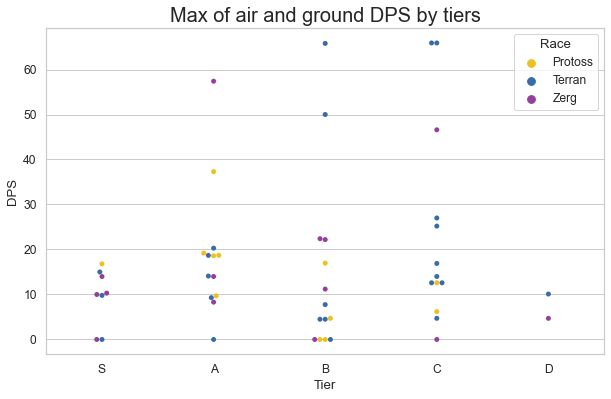

In [60]:
g = sns.swarmplot(x=df[df.Psionic == False].Tier, order=tiers_order,
            y=df[df.Psionic == False][['Ground_DPS','Air_DPS']].max(axis=1),
            hue=df.Race, palette=sc_race_colors
            )
g.set_ylabel('DPS')
g.set_title('Max of air and ground DPS by tiers', fontsize=title_font_size);

### Resources

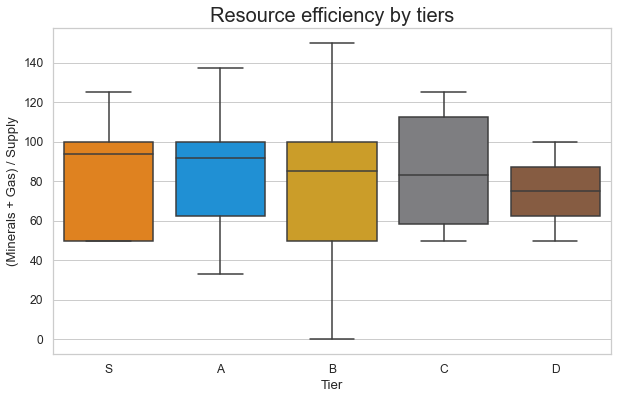

In [61]:
g = sns.boxplot(x=df.Tier, order=tiers_order,
            y=(df.Gas + df.Minerals) / df.Supply,
            palette = tiers_colors,
            # hue=df.Race, palette=sc_race_colors
            )
g.set_ylabel('(Minerals + Gas) / Supply')
g.set_title('Resource efficiency by tiers', fontsize=title_font_size);

### Move speed

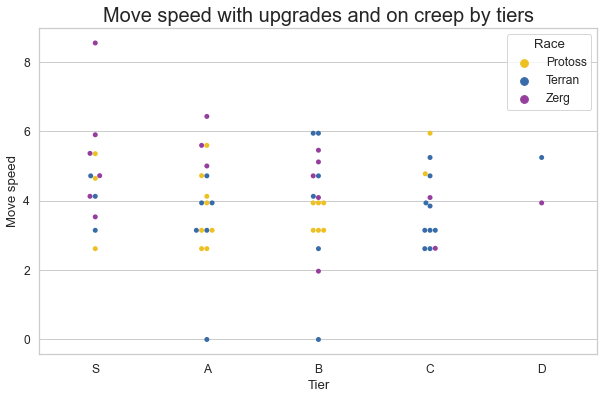

In [75]:
g = sns.swarmplot(x=df.Tier, order=tiers_order,
            y=df.Max_speed,
            hue=df.Race, palette=sc_race_colors
            )
g.set_ylabel('Move speed')
g.set_title('Move speed with upgrades and on creep by tiers', fontsize=title_font_size);


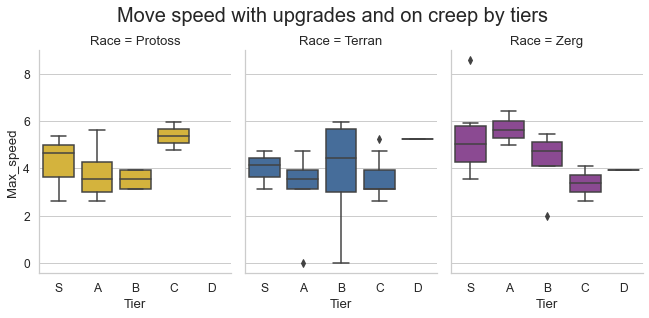

In [63]:
g = sns.catplot(x='Tier', order=tiers_order,
                y='Max_speed',
                data = df,
                hue='Race', palette=sc_race_colors,
                kind='box',
                col = 'Race',
                height=4, aspect=0.75,
                dodge=0,
                )
g.fig.suptitle('Move speed with upgrades and on creep by tiers', y=1.05, fontsize=title_font_size);

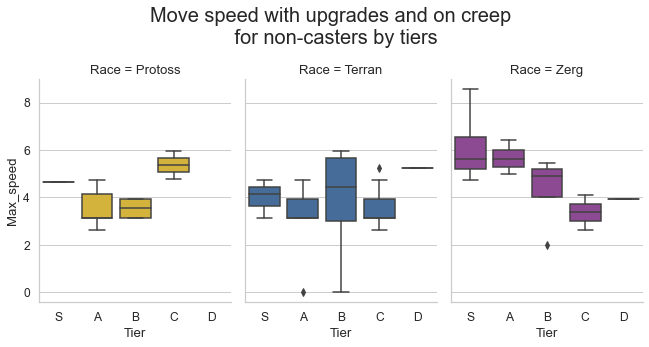

In [64]:
g = sns.catplot(x='Tier', order=tiers_order,
                y='Max_speed',
                data = df[df.Psionic == False],
                hue='Race', palette=sc_race_colors,
                kind='box',
                col = 'Race',
                height=4, aspect=0.75,
                dodge=0,
                )
g.fig.suptitle('Move speed with upgrades and on creep \n for non-casters by tiers', y=1.15, fontsize=title_font_size);

In [73]:
def get_stats(query:str, x:str, y:str, df=df):
    if query is not None:
        q = df.query(query).loc[:, (x, y)]
    else:
        q = df.loc[:, (x, y)]
    return pearsonr(q[x], q[y])


def get_race_stats(x:str, y:str, filter_name:str, df:pd.DataFrame):
    data = []
    for race in df.Race.cat.categories:
        corr, pvalue = get_stats(f'Race == "{race}"', x, y, df)
        data.append((race, filter_name, corr, pvalue))  
        
    corr, pvalue = get_stats(None, x , y, df)
    data.append(('all_races', filter_name, corr, pvalue))
    return data


data = []
data.extend(get_race_stats('Max_speed', 'Tier_value', 'all_units', df))
data.extend(get_race_stats('Max_speed', 'Tier_value', 'non-casters', df[df.Psionic == False]))
    
move_corr=pd.DataFrame(data, columns=('race', 'unit_filter', 'correlation', 'p_value'))


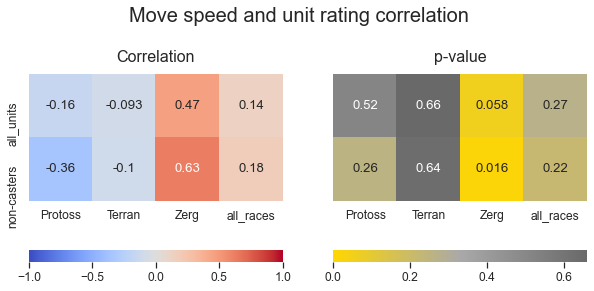

In [74]:
fig, axes = plt.subplots(1, 2, sharey=True)

sns.heatmap(data=move_corr.pivot('unit_filter', 'race', 'correlation'),
            ax=axes[0],
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True,
            square=True,
            cbar_kws={"orientation": "horizontal"},
            )
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title('Correlation', fontsize=16, y=1.05)

sns.heatmap(data=move_corr.pivot('unit_filter', 'race', 'p_value'),
            ax=axes[1],
            vmin=0,
            # vmax=1,
            cmap=cmap_gold_gray,
            # cmap='GrGl',
            # cmap='pink_r',
            # cmap='viridis_r',
            # cmap='magma_r',
            annot=True,
            square=True,
            cbar_kws={"orientation": "horizontal"},
            )
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title('p-value', fontsize=16, y=1.05)

fig.suptitle('Move speed and unit rating correlation', y=0.8, fontsize=title_font_size);